In [54]:
import pandas as pd
import numpy as np
#!pip install catBoost
#!pip install sktime
from catboost import CatBoostRegressor, CatBoostClassifier
import mlflow
from sklearn.model_selection import TimeSeriesSplit#разбиение датасета для временного ряда

from sklearn.metrics import mean_squared_error,mean_absolute_error #метрики
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric = True)#метрика sMAPE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 5.8 MB/s eta 0:00:00


In [2]:
transaction = pd.read_parquet('https://github.com/m6129/UrFU_2022_python/raw/main/all_xackatons/GPN2023/transaction_df.parquet')

In [3]:
transaction

,product,price,amount,place,datetime
0,Целебные травы,3.90,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.90,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.90,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.90,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.90,1.367161,Анор Лондо,2216-01-02 05:33:00
...,...,...,...,...,...
875031,Эстус,9.28,1.079104,Фалькония,2218-09-27 14:50:00
875032,Эстус,9.28,1.580617,Фалькония,2218-09-27 06:16:00
875033,Эстус,9.28,1.738492,Фалькония,2218-09-27 11:14:00
875034,Эстус,9.28,0.430340,Фалькония,2218-09-27 22:24:00


готовим датасет

In [4]:
place_transaction = transaction[transaction['place'].isna()==False].copy()#поэтому удаляю
price_transaction_test_ = place_transaction[place_transaction['price']<0]#1 часть датафрейма
price_transaction_train_ = place_transaction[place_transaction['price']>0]#2 часть датафрейма
price_transaction_test = place_transaction[place_transaction['price']<0]#54321 строки нужно предсказать
price_transaction_train = place_transaction[place_transaction['price']>0]#тренировочный датасет

In [5]:
mlflow.set_tracking_uri("http://192.168.56.117:5000")#настраиваю сеть #можно складывать в единую базу данных типа "sqlite:///mlflow.db"

In [6]:
mlflow.set_experiment("transaction_03")#название всегда должно быть уникальным, даже если удалить его из UI
mlflow.start_run()#запуск процесса

2023/11/22 08:28:15 INFO mlflow.tracking.fluent: Experiment with name 'transaction_03' does not exist. Creating a new experiment.


<ActiveRun: >

In [7]:
#mlflow.end_run()#ЗАВЕРШИТЬ ПРОЦЕСС

In [8]:
price_transaction_train

,product,price,amount,place,datetime
0,Целебные травы,3.90,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.90,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.90,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.90,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.90,1.367161,Анор Лондо,2216-01-02 05:33:00
...,...,...,...,...,...
875031,Эстус,9.28,1.079104,Фалькония,2218-09-27 14:50:00
875032,Эстус,9.28,1.580617,Фалькония,2218-09-27 06:16:00
875033,Эстус,9.28,1.738492,Фалькония,2218-09-27 11:14:00
875034,Эстус,9.28,0.430340,Фалькония,2218-09-27 22:24:00


In [9]:
price_transaction_train['datetime'] = pd.to_datetime(price_transaction_train['datetime'])
price_transaction_train['datetime_int'] = price_transaction_train['datetime'].astype(int)

/tmp/ipykernel_167/879348289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_transaction_train['datetime'] = pd.to_datetime(price_transaction_train['datetime'])
/tmp/ipykernel_167/879348289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_transaction_train['datetime_int'] = price_transaction_train['datetime'].astype(int)


In [10]:
X = price_transaction_train.drop(['datetime','price'],axis=1)

In [11]:
X

,product,amount,place,datetime_int
0,Целебные травы,1.242125,Анор Лондо,7763099280000000
1,Целебные травы,-0.079689,Анор Лондо,7763098860000000
2,Целебные травы,0.882450,Анор Лондо,7763050980000000
3,Целебные травы,0.621377,Анор Лондо,7763051520000000
4,Целебные травы,1.367161,Анор Лондо,7763059980000000
...,...,...,...,...
875031,Эстус,1.079104,Фалькония,7849407000000000
875032,Эстус,1.580617,Фалькония,7849376160000000
875033,Эстус,1.738492,Фалькония,7849394040000000
875034,Эстус,0.430340,Фалькония,7849434240000000


In [18]:
#mlflow.sklearn.autolog(disable=True)#автологирование

In [12]:
FEATURES = ['amount','datetime_int','place','product']
CATEGORIAL_FEATURES = ['place','product']
TARGET = ['price']

In [13]:
mlflow.log_param('features',FEATURES)#стиль vk https://youtu.be/1cI_bonO2Vo
mlflow.log_param('categorial_features',CATEGORIAL_FEATURES) #ЕСЛИ ХОЧЕШЬ ПОМЕНЯТЬ значения в .log_param, завершай эксперимент и создавай новый
mlflow.log_param('target',TARGET)

['price']

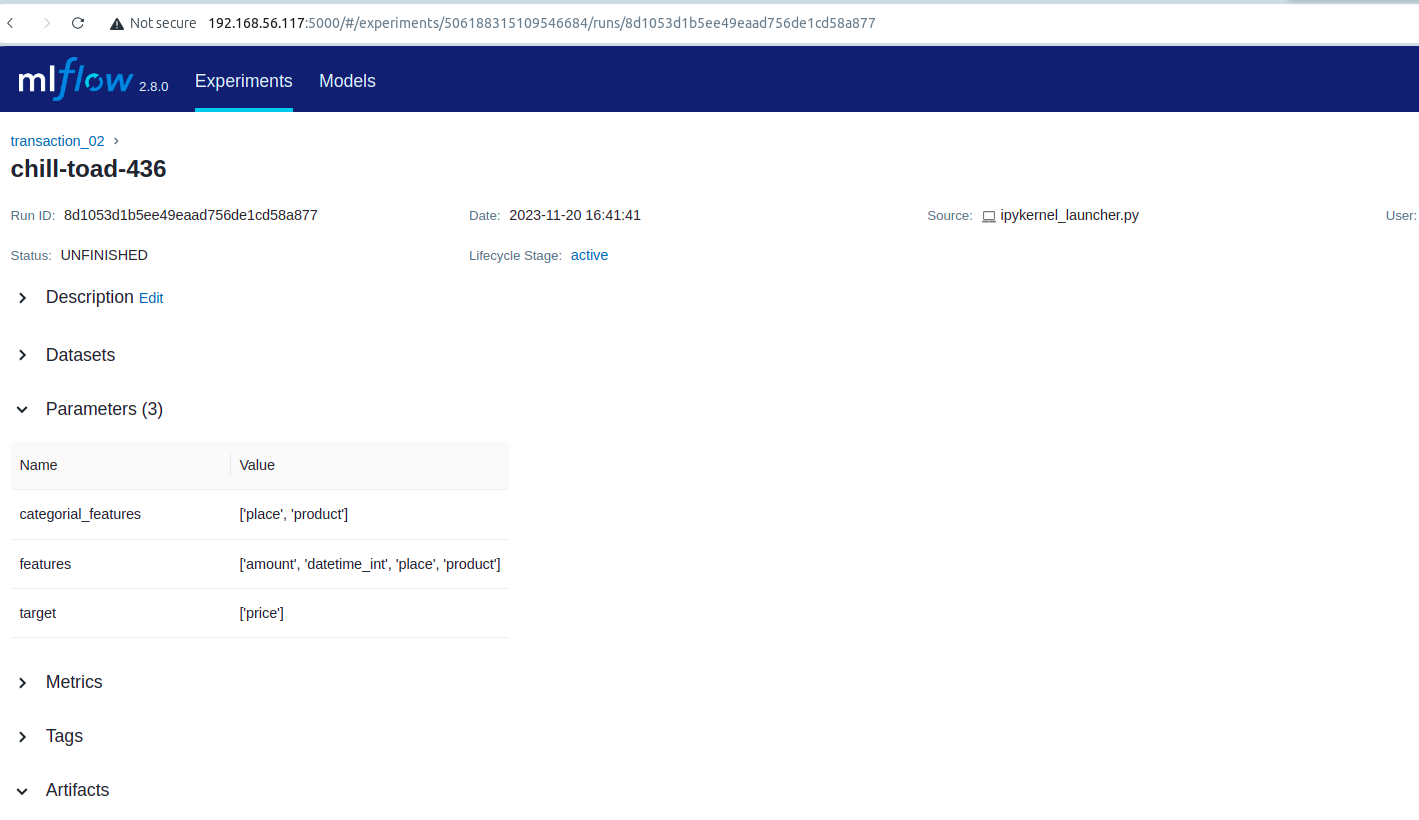

In [19]:
X = price_transaction_train[FEATURES]
y = price_transaction_train[TARGET]

In [32]:
X = pd.get_dummies(X)

In [33]:
tscv = TimeSeriesSplit(n_splits=12)
for fold,(train_index, val_index) in enumerate(tscv.split(X,y)):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [21]:
# Import the Pool class from catboost для grdisearch который я не люлю
#from catboost import Pool
#train_pool = Pool(X_train, y_train, cat_features = CATEGORIAL_FEATURES, feature_names=FEATURES)
#test_pool = Pool(X_val, cat_features = CATEGORIAL_FEATURES)

In [47]:
modelR = CatBoostRegressor(eval_metric='SMAPE',random_seed=2,verbose =100)

In [42]:
mlflow.log_param('model_type',modelR.__class__)#добавит в paramets информацию об использованной модели

catboost.core.CatBoostRegressor

In [43]:
mlflow.set_tags(tags = {"auto_tracking": "false", "framework": "Catboost"}) #любая дополнительная информация к эсперименту(тэги можно удалять и менять в самом mlflow)

In [50]:
modelR.fit(X_train, y_train)

Learning rate set to 0.116707
0:	learn: 35.8689618	total: 141ms	remaining: 2m 20s
100:	learn: 1.8475247	total: 7.49s	remaining: 1m 6s
200:	learn: 1.3784248	total: 14.8s	remaining: 58.9s
300:	learn: 1.1686713	total: 24.1s	remaining: 56s
400:	learn: 1.0317790	total: 31.2s	remaining: 46.6s
500:	learn: 0.9445368	total: 38.2s	remaining: 38s
600:	learn: 0.8759239	total: 45.1s	remaining: 29.9s
700:	learn: 0.8213075	total: 51.8s	remaining: 22.1s
800:	learn: 0.7717184	total: 58.5s	remaining: 14.5s
900:	learn: 0.7319732	total: 1m 5s	remaining: 7.18s
999:	learn: 0.6949668	total: 1m 12s	remaining: 0us


In [56]:
score = modelR.predict(X_val)
print('sMAPE', smape(y_val, score).round(4))
print("mae",mean_absolute_error(y_val, score).round(4))
print("mse", mean_squared_error(y_val, score).round(4))#сногсшибательные результаты

sMAPE 0.0823
mae 0.9516
mse 1.4604


/opt/conda/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/opt/conda/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


In [57]:
modelR.fit(X, y)

Learning rate set to 0.118192
0:	learn: 34.0869525	total: 109ms	remaining: 1m 48s
100:	learn: 1.8693974	total: 8.23s	remaining: 1m 13s
200:	learn: 1.3958613	total: 16.8s	remaining: 1m 6s
300:	learn: 1.1672838	total: 25.5s	remaining: 59.2s
400:	learn: 1.0319904	total: 33.7s	remaining: 50.3s
500:	learn: 0.9369105	total: 41.7s	remaining: 41.6s
600:	learn: 0.8702509	total: 50s	remaining: 33.2s
700:	learn: 0.8108338	total: 57.9s	remaining: 24.7s
800:	learn: 0.7657197	total: 1m 6s	remaining: 16.4s
900:	learn: 0.7230675	total: 1m 14s	remaining: 8.16s
999:	learn: 0.6884819	total: 1m 22s	remaining: 0us


In [ ]:
#19 минута